# **Klasifikasi Gambar Penyakit Stroke**

## **Objective:**   
Membangun sebuah model menggunakan CNN yang dapat mengklasifikasikan stroke  menggunakan gambar medis CT Scan Otak.

## **Sumber Dataset**
https://www.kaggle.com/datasets/orvile/inme-veri-seti-stroke-dataset

# **Import Libraries**

In [4]:
# Mengimpor libraries umum yang sering digunakan
import os, shutil
import random
from random import sample
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq

# Mengimpor libraries untuk visualisasi
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Mengimpor libraries untuk pemrosesan data gambar
import cv2
from PIL import Image
import skimage
from skimage import io

# Mengimpor libraries untuk pembuatan dan evaluasi model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers, optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Mengabaikan peringatan
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
# Mencetak versi TensorFlow yang sedang digunakan
print(tf.__version__)

2.18.0


# **Data Loading**

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Plot gambar sampel untuk semua kelas**

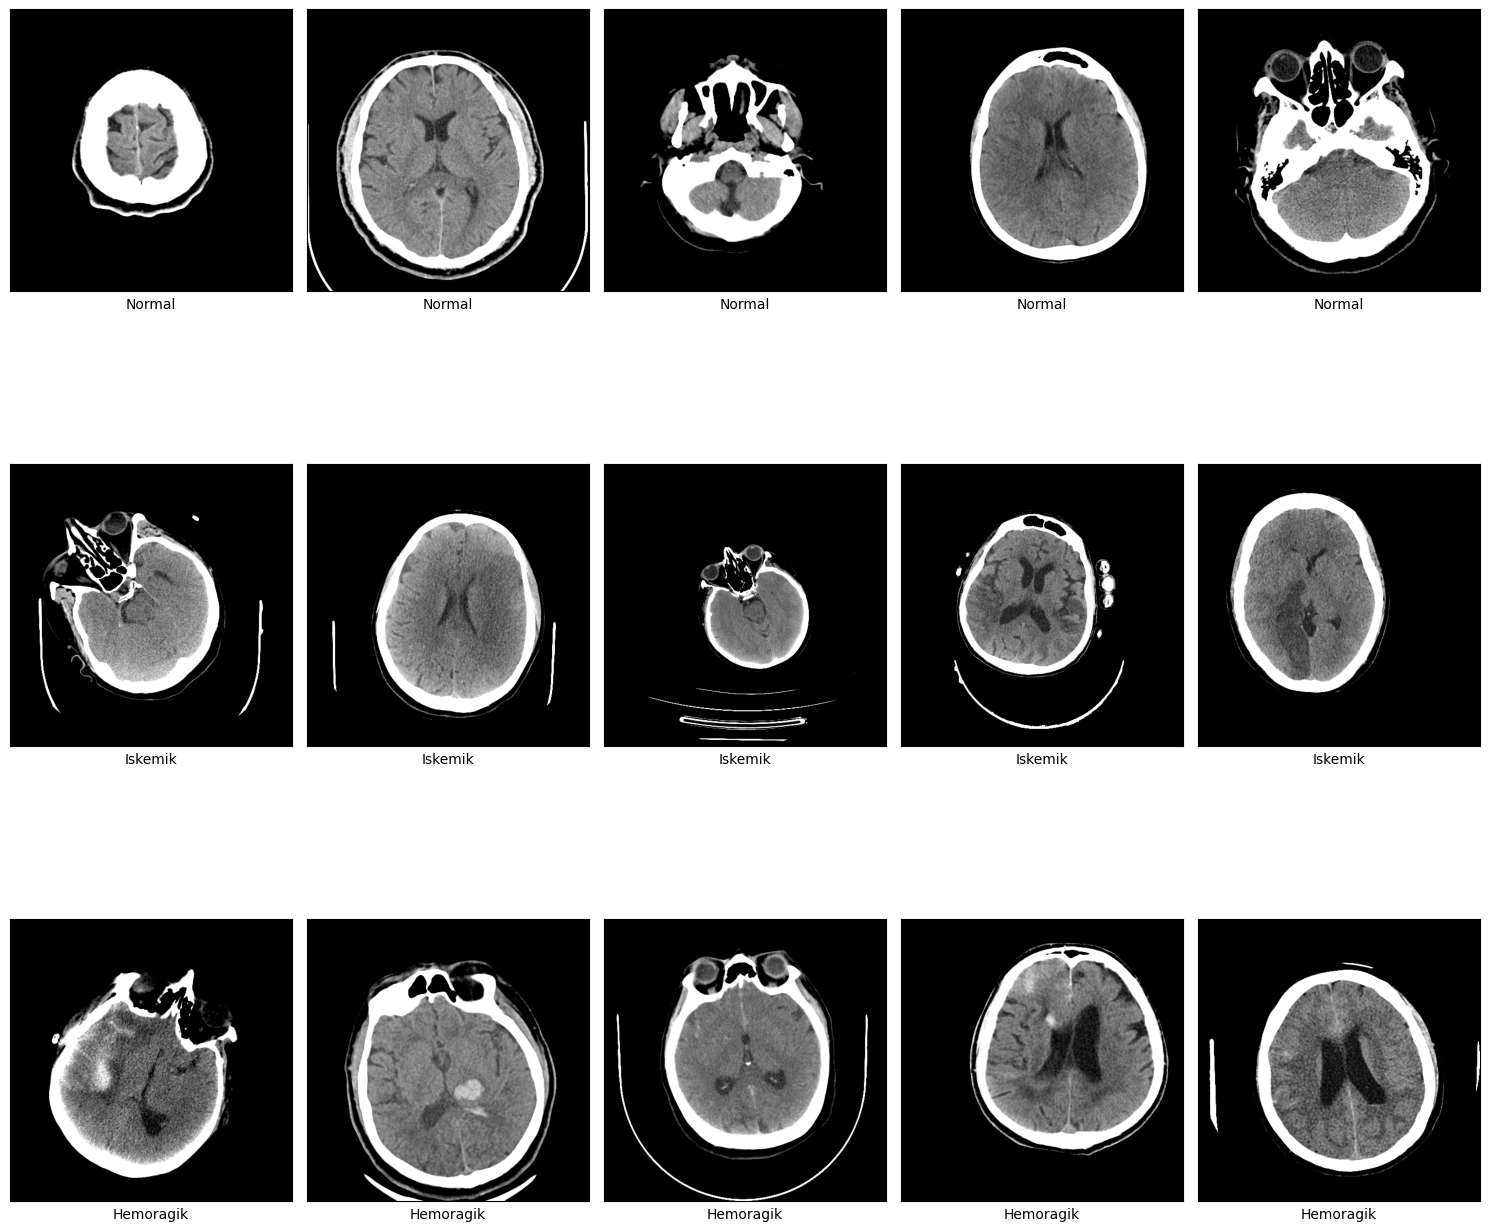

In [7]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
ct_image = {}

# Tentukan path sumber train
path = "/content/drive/MyDrive/Kuliah/Skripsi/Program/Dataset"
for i in os.listdir(path):
    ct_image[i] = os.listdir(os.path.join(path, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(ct_image.keys()), 5, figsize=(15, 15))

for i, class_name in enumerate(os.listdir(path)):
    images = np.random.choice(ct_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(path, class_name, image_name)
        img = Image.open(img_path).convert("L")  # Konversi menjadi skala keabuan
        axs[i, j].imshow(img, cmap='gray')
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])


fig.tight_layout()

## **Plot distribusi gambar di seluruh kelas**

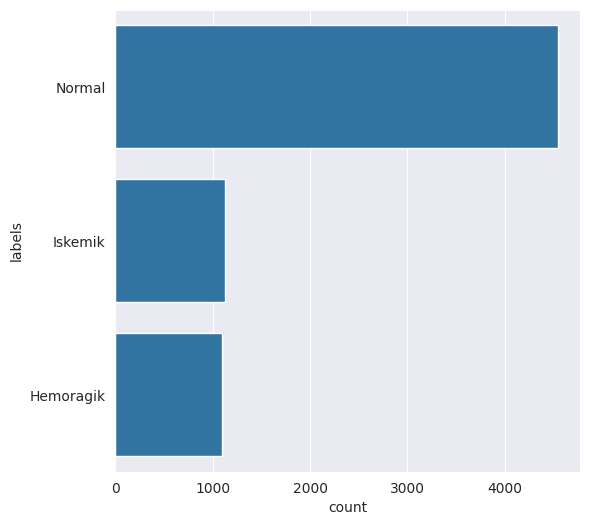

In [8]:
# Create a list that stores data for each filenames, filepaths, and labels in the data
file_name = []
labels = []
full_path = []

# Get data image filenames, filepaths, labels one by one with looping, and store them as dataframe
for path, subdirs, files in os.walk(path):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

distribution_train = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})

# Plot the distribution of images across the classes
Label = distribution_train['labels']
plt.figure(figsize = (6,6))
sns.set_style("darkgrid")
plot_data = sns.countplot(Label)

In [9]:
print("\nJumlah total gambar per kelas sebelum diseimbangkan:")
print(distribution_train['labels'].value_counts())


Jumlah total gambar per kelas sebelum diseimbangkan:
labels
Normal       4551
Iskemik      1130
Hemoragik    1093
Name: count, dtype: int64


## **Undersampling kelas Normal**

In [10]:
# Hitung ukuran target (ambil nilai terendah dari dua kelas minoritas)
min_count = distribution_train.query("labels != 'Normal'")['labels'].value_counts().min()
print("Target sampel Normal:", min_count)

Target sampel Normal: 1093


In [11]:
# Undersampling kelas Normal
df_normal     = distribution_train.query("labels == 'Normal'") \
                                  .sample(n=min_count, random_state=42)
df_iskemik    = distribution_train.query("labels == 'Iskemik'")
df_hemoragik  = distribution_train.query("labels == 'Hemoragik'")

balanced_df = pd.concat([df_normal, df_iskemik, df_hemoragik],
                        ignore_index=True).sample(frac=1, random_state=42)

In [12]:
print("\nDistribusi sesudah undersampling:")
print(balanced_df['labels'].value_counts())


Distribusi sesudah undersampling:
labels
Iskemik      1130
Normal       1093
Hemoragik    1093
Name: count, dtype: int64


# **Data Splitting : Training and Testing**

In [13]:
# Variabel yang digunakan pada pemisahan data ini dimana variabel x = data path dan y = data labels
X= balanced_df['path']
y= balanced_df['labels']

# Split dataset awal menjadi data train dan test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=300)

In [14]:
# Menyatukan kedalam masing-masing dataframe
df_tr = pd.DataFrame({'path':X_train,'labels':y_train,'set':'train'})
df_te = pd.DataFrame({'path':X_test,'labels':y_test,'set':'test'})

In [15]:
# Print hasil diatas untuk melihat panjang size data training dan testing
print('train size', len(df_tr))
print('test size', len(df_te))

train size 2652
test size 664


In [16]:
# Gabungkan DataFrame df_tr dan df_te
df_all = pd.concat([df_tr, df_te], ignore_index=True)

print('===================================================== \n')
print(df_all.groupby(['set', 'labels']).size(), '\n')
print('===================================================== \n')

# Cek sample data
print(df_all.sample(5))


set    labels   
test   Hemoragik    218
       Iskemik      212
       Normal       234
train  Hemoragik    875
       Iskemik      918
       Normal       859
dtype: int64 


                                                   path     labels    set
1453  /content/drive/MyDrive/Kuliah/Skripsi/Program/...     Normal  train
1360  /content/drive/MyDrive/Kuliah/Skripsi/Program/...     Normal  train
2093  /content/drive/MyDrive/Kuliah/Skripsi/Program/...    Iskemik  train
222   /content/drive/MyDrive/Kuliah/Skripsi/Program/...  Hemoragik  train
645   /content/drive/MyDrive/Kuliah/Skripsi/Program/...     Normal  train


In [17]:
dataset_path = pathlib.Path('/content/drive/MyDrive/Kuliah/Skripsi/Program/dataset_final')
dataset_path.mkdir(parents=True, exist_ok=True)

In [18]:
for _, row in tq(df_all.iterrows(), total=len(df_all)):
    src  = row['path']
    set_ = row['set']
    lbl  = row['labels']

    if not os.path.exists(src):
        print(f"⚠️  File tidak ditemukan → {src}")
        continue

    dst_dir = dataset_path / set_ / lbl
    dst_dir.mkdir(parents=True, exist_ok=True)

    dst = dst_dir / os.path.basename(src)

    if not dst.exists():
        shutil.copy2(src, dst)

print("✔️  Penyalinan selesai")

  0%|          | 0/3316 [00:00<?, ?it/s]

✔️  Penyalinan selesai


In [19]:
# Cek jumlah gambar per subset & label
for subset in ['train', 'test']:
    print(f"\n{subset.upper()} SET")
    for lbl in ['Iskemik', 'Hemoragik', 'Normal']:
        n = len(os.listdir(dataset_path / subset / lbl))
        print(f"  {lbl:10s}: {n}")


TRAIN SET
  Iskemik   : 918
  Hemoragik : 875
  Normal    : 859

TEST SET
  Iskemik   : 212
  Hemoragik : 218
  Normal    : 234


In [20]:
TRAIN_DIR = str(dataset_path / 'train')
TEST_DIR  = str(dataset_path / 'test')

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2)

test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    subset='training',
    batch_size=32,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=True)

val_gen = datagen.flow_from_directory(
    TRAIN_DIR,
    subset='validation',
    batch_size=32,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False)

test_gen = test_datagen.flow_from_directory(
    TEST_DIR,
    batch_size=1,
    target_size=(224, 224),
    color_mode='grayscale',
    class_mode='categorical',
    shuffle=False)

Found 2123 images belonging to 3 classes.
Found 529 images belonging to 3 classes.
Found 664 images belonging to 3 classes.


# **CNN Architecture:**

In [21]:
# tf.keras.backend.clear_session()

####################### Init sequential model ##################################
model_1 = Sequential()

# ######################### Input layer with Fully Connected Layer ################################
# 1st Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(32, (3, 3), padding='same', activation='relu',input_shape=(224, 224, 1)))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D(pool_size=(2, 2)))

# 2nd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(64, (3, 3),padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 3rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

# 4rd Convolutional layer, Batch Normalization layer, and Pooling layer
model_1.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
model_1.add(BatchNormalization())
model_1.add(MaxPool2D((2, 2)))

######################### Fully Connected Layer ################################
# Flatten layer
model_1.add(Flatten())
# 1nd Dense Layer
model_1.add(Dense(256, activation = 'relu'))
# 1nd Dropout Layer
model_1.add(Dropout(0.5))
# 2nd Dense Layer
model_1.add(Dense(128, activation = 'relu'))
# 2nd Dropout Layer
model_1.add(Dropout(0.3))

# Final Dense layer => For output prediction 1 mean (3 classes), softmax
model_1.add(Dense(3, activation='softmax'))

######################### Compile Model ################################
model_1.compile(optimizer= AdamW(learning_rate=1e-4),
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Summary of the Model Architecture
print(model_1.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 224, 224, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 28, 28, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 50176)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    12,845,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,268,355 (50.61 MB)

 Trainable params: 13,267,395 (50.61 MB)

 Non-trainable params: 960 (3.75 KB)

None


In [22]:
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint("best_ct_model.h5", monitor='val_loss', save_best_only=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4)

In [23]:
history_1 = model_1.fit(
    train_gen,
    epochs=100,
    validation_data=val_gen,
    callbacks=[early_stop, checkpoint, lr_scheduler]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.3843 - loss: 2.9180

67/67 ━━━━━━━━━━━━━━━━━━━━ 631s 9s/step - accuracy: 0.3848 - loss: 2.9062 - val_accuracy: 0.3422 - val_loss: 1.1046 - learning_rate: 1.0000e-04
Epoch 2/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 275ms/step - accuracy: 0.4634 - loss: 1.0512 - val_accuracy: 0.3535 - val_loss: 1.3185 - learning_rate: 1.0000e-04
Epoch 3/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 245ms/step - accuracy: 0.4954 - loss: 0.9864 - val_accuracy: 0.3459 - val_loss: 1.7759 - learning_rate: 1.0000e-04
Epoch 4/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.5351 - loss: 0.9255 - val_accuracy: 0.3459 - val_loss: 1.3543 - learning_rate: 1.0000e-04
Epoch 5/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.5689 - loss: 0.9013

67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 244ms/step - accuracy: 0.5689 - loss: 0.9010 - val_accuracy: 0.4707 - val_loss: 1.0456 - learning_rate: 1.0000e-04
Epoch 6/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.5898 - loss: 0.8208

67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 241ms/step - accuracy: 0.5899 - loss: 0.8208 - val_accuracy: 0.5633 - val_loss: 0.9591 - learning_rate: 1.0000e-04
Epoch 7/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6213 - loss: 0.8199

67/67 ━━━━━━━━━━━━━━━━━━━━ 23s 286ms/step - accuracy: 0.6214 - loss: 0.8194 - val_accuracy: 0.6333 - val_loss: 0.8511 - learning_rate: 1.0000e-04
Epoch 8/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6665 - loss: 0.7270

67/67 ━━━━━━━━━━━━━━━━━━━━ 18s 243ms/step - accuracy: 0.6665 - loss: 0.7268 - val_accuracy: 0.7316 - val_loss: 0.7630 - learning_rate: 1.0000e-04
Epoch 9/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step - accuracy: 0.6777 - loss: 0.6565

67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 243ms/step - accuracy: 0.6778 - loss: 0.6565 - val_accuracy: 0.7807 - val_loss: 0.6808 - learning_rate: 1.0000e-04
Epoch 10/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.7072 - loss: 0.6370

67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 253ms/step - accuracy: 0.7072 - loss: 0.6368 - val_accuracy: 0.7599 - val_loss: 0.6165 - learning_rate: 1.0000e-04
Epoch 11/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step - accuracy: 0.7552 - loss: 0.5575

67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 252ms/step - accuracy: 0.7551 - loss: 0.5576 - val_accuracy: 0.8204 - val_loss: 0.5320 - learning_rate: 1.0000e-04
Epoch 12/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step - accuracy: 0.7780 - loss: 0.4961

67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 248ms/step - accuracy: 0.7780 - loss: 0.4963 - val_accuracy: 0.8110 - val_loss: 0.5183 - learning_rate: 1.0000e-04
Epoch 13/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.7861 - loss: 0.4816

67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 240ms/step - accuracy: 0.7859 - loss: 0.4817 - val_accuracy: 0.8318 - val_loss: 0.4648 - learning_rate: 1.0000e-04
Epoch 14/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - accuracy: 0.8176 - loss: 0.4334 - val_accuracy: 0.8129 - val_loss: 0.4818 - learning_rate: 1.0000e-04
Epoch 15/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8111 - loss: 0.4200

67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 244ms/step - accuracy: 0.8112 - loss: 0.4199 - val_accuracy: 0.8242 - val_loss: 0.4325 - learning_rate: 1.0000e-04
Epoch 16/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.8393 - loss: 0.3648

67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 239ms/step - accuracy: 0.8392 - loss: 0.3649 - val_accuracy: 0.8412 - val_loss: 0.4206 - learning_rate: 1.0000e-04
Epoch 17/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.8281 - loss: 0.3618 - val_accuracy: 0.8336 - val_loss: 0.4286 - learning_rate: 1.0000e-04
Epoch 18/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.8422 - loss: 0.3476

67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 238ms/step - accuracy: 0.8421 - loss: 0.3476 - val_accuracy: 0.8544 - val_loss: 0.3810 - learning_rate: 1.0000e-04
Epoch 19/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step - accuracy: 0.8692 - loss: 0.2999

67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 278ms/step - accuracy: 0.8691 - loss: 0.3000 - val_accuracy: 0.8771 - val_loss: 0.3610 - learning_rate: 1.0000e-04
Epoch 20/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.8577 - loss: 0.2806 - val_accuracy: 0.8620 - val_loss: 0.3995 - learning_rate: 1.0000e-04
Epoch 21/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.8864 - loss: 0.2625 - val_accuracy: 0.8677 - val_loss: 0.3659 - learning_rate: 1.0000e-04
Epoch 22/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8558 - loss: 0.3212

67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - accuracy: 0.8561 - loss: 0.3206 - val_accuracy: 0.8752 - val_loss: 0.3313 - learning_rate: 1.0000e-04
Epoch 23/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8865 - loss: 0.2542

67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 289ms/step - accuracy: 0.8863 - loss: 0.2546 - val_accuracy: 0.8866 - val_loss: 0.3199 - learning_rate: 1.0000e-04
Epoch 24/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 229ms/step - accuracy: 0.8985 - loss: 0.2248 - val_accuracy: 0.8922 - val_loss: 0.3367 - learning_rate: 1.0000e-04
Epoch 25/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.8964 - loss: 0.2139

67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 239ms/step - accuracy: 0.8965 - loss: 0.2139 - val_accuracy: 0.8828 - val_loss: 0.3181 - learning_rate: 1.0000e-04
Epoch 26/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9008 - loss: 0.2103 - val_accuracy: 0.8620 - val_loss: 0.3709 - learning_rate: 1.0000e-04
Epoch 27/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step - accuracy: 0.9006 - loss: 0.2399

67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 279ms/step - accuracy: 0.9007 - loss: 0.2396 - val_accuracy: 0.8960 - val_loss: 0.3111 - learning_rate: 1.0000e-04
Epoch 28/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 232ms/step - accuracy: 0.9039 - loss: 0.2175 - val_accuracy: 0.8922 - val_loss: 0.3260 - learning_rate: 1.0000e-04
Epoch 29/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 234ms/step - accuracy: 0.9240 - loss: 0.1951 - val_accuracy: 0.8790 - val_loss: 0.3832 - learning_rate: 1.0000e-04
Epoch 30/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 229ms/step - accuracy: 0.9186 - loss: 0.1853 - val_accuracy: 0.8922 - val_loss: 0.3334 - learning_rate: 1.0000e-04
Epoch 31/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 236ms/step - accuracy: 0.9213 - loss: 0.1827 - val_accuracy: 0.8809 - val_loss: 0.3307 - learning_rate: 1.0000e-04
Epoch 32/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.9261 - loss: 0.1672 - val_accuracy: 0.8866 - val_loss: 0.3153 - learning_rate: 5.0000e-05
Epoch 33/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - ac

67/67 ━━━━━━━━━━━━━━━━━━━━ 17s 250ms/step - accuracy: 0.9394 - loss: 0.1120 - val_accuracy: 0.9036 - val_loss: 0.2897 - learning_rate: 5.0000e-05
Epoch 35/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 233ms/step - accuracy: 0.9334 - loss: 0.1333 - val_accuracy: 0.8979 - val_loss: 0.2932 - learning_rate: 5.0000e-05
Epoch 36/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 21s 239ms/step - accuracy: 0.9451 - loss: 0.1142 - val_accuracy: 0.9074 - val_loss: 0.3039 - learning_rate: 5.0000e-05
Epoch 37/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9462 - loss: 0.1183 - val_accuracy: 0.9036 - val_loss: 0.3083 - learning_rate: 5.0000e-05
Epoch 38/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 235ms/step - accuracy: 0.9474 - loss: 0.1119 - val_accuracy: 0.9093 - val_loss: 0.2976 - learning_rate: 5.0000e-05
Epoch 39/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step - accuracy: 0.9542 - loss: 0.1017

67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 241ms/step - accuracy: 0.9542 - loss: 0.1017 - val_accuracy: 0.9168 - val_loss: 0.2765 - learning_rate: 2.5000e-05
Epoch 40/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.9540 - loss: 0.0950

67/67 ━━━━━━━━━━━━━━━━━━━━ 19s 272ms/step - accuracy: 0.9540 - loss: 0.0950 - val_accuracy: 0.9187 - val_loss: 0.2665 - learning_rate: 2.5000e-05
Epoch 41/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 232ms/step - accuracy: 0.9613 - loss: 0.0898 - val_accuracy: 0.9130 - val_loss: 0.3023 - learning_rate: 2.5000e-05
Epoch 42/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 228ms/step - accuracy: 0.9465 - loss: 0.1024 - val_accuracy: 0.8979 - val_loss: 0.2983 - learning_rate: 2.5000e-05
Epoch 43/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 231ms/step - accuracy: 0.9628 - loss: 0.0799 - val_accuracy: 0.9130 - val_loss: 0.2942 - learning_rate: 2.5000e-05
Epoch 44/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step - accuracy: 0.9683 - loss: 0.0792 - val_accuracy: 0.9130 - val_loss: 0.3235 - learning_rate: 2.5000e-05
Epoch 45/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 20s 233ms/step - accuracy: 0.9642 - loss: 0.0832 - val_accuracy: 0.9112 - val_loss: 0.3156 - learning_rate: 1.2500e-05
Epoch 46/100
67/67 ━━━━━━━━━━━━━━━━━━━━ 15s 231ms/step - ac

In [24]:
# Evaluasi di data test
test_loss, test_acc = model_1.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

664/664 ━━━━━━━━━━━━━━━━━━━━ 239s 359ms/step - accuracy: 0.9159 - loss: 0.2458
Test Accuracy: 0.9187
Test Loss: 0.2610


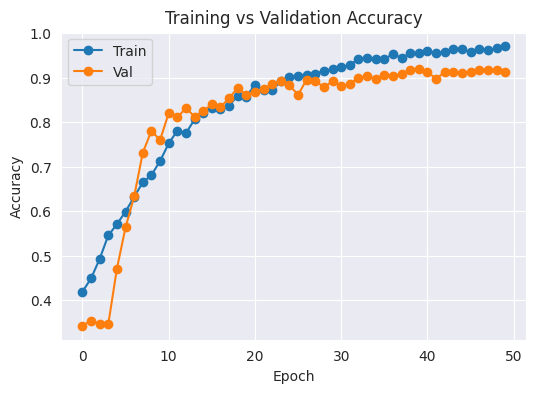

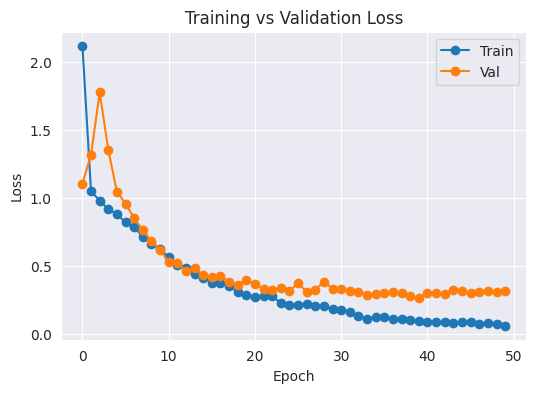

In [25]:
acc = history_1.history['accuracy']
val_acc = history_1.history['val_accuracy']
loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

epochs = range(len(acc))

plt.figure(figsize=(6,4))
plt.plot(epochs, acc, '-o', label='Train')
plt.plot(epochs, val_acc, '-o', label='Val')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(epochs, loss, '-o', label='Train')
plt.plot(epochs, val_loss, '-o', label='Val')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

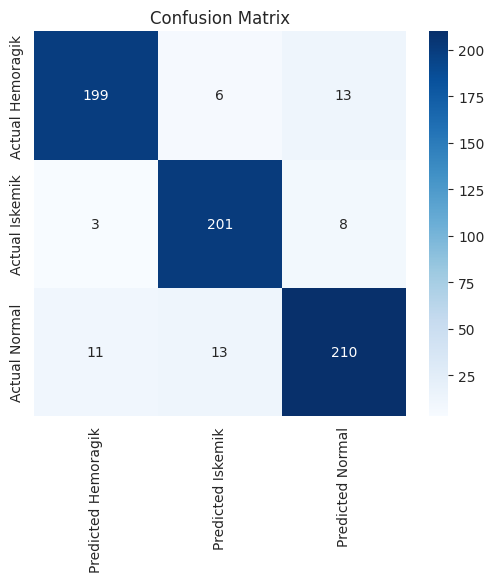



              precision    recall  f1-score   support

   Hemoragik     0.9343    0.9128    0.9234       218
     Iskemik     0.9136    0.9481    0.9306       212
      Normal     0.9091    0.8974    0.9032       234

    accuracy                         0.9187       664
   macro avg     0.9190    0.9195    0.9191       664
weighted avg     0.9188    0.9187    0.9186       664



In [26]:
test_gen.reset()
probs = model_1.predict(test_gen, verbose=0)
preds = np.argmax(probs, axis=1)

y_true = test_gen.classes
class_names = list(test_gen.class_indices.keys())

# Print Confusion Matrix
cm = confusion_matrix(y_true, preds)
cm_df = pd.DataFrame(cm,
                     index=[f"Actual {c}"   for c in class_names],
                     columns=[f"Predicted {c}" for c in class_names])

plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.ylabel("")
plt.xlabel("")
plt.show()

# Print Classification Report
print("\n")
print(classification_report(y_true, preds,
                            target_names=class_names,
                            digits=4))